In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from astropy.io import fits
from astropy.wcs import WCS
from itertools import product
from m33_utils import open_and_select
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from matplotlib import patheffects

np.seterr(all='ignore')

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

In [2]:
def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1,
                 norm='Normalize', n_colors=None, norm_args={},
                 offset=0.0175, width=0.0225, label='Number of stars'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(**norm_args, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl),
                        cax=cax, label=label)
    return cbar

In [3]:
ds = open_and_select('../legacy_phot/M33_full_matched.hdf5')

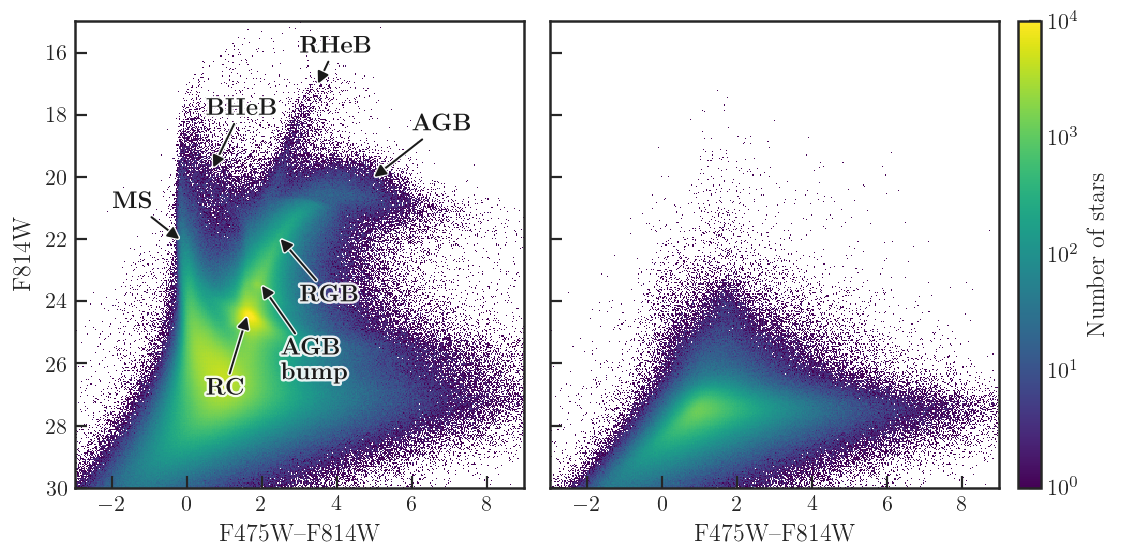

In [24]:
# W14 Fig 7

colormap, vmin, vmax = 'viridis', 1, 1e4
cmap = getattr(mpl.cm, colormap)
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

opt_lim = [[-3, 9], [30, 15]]

fig = plt.figure(figsize=(7.2, 4))
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=opt_lim,
        f='log10', colorbar=False, colormap=colormap,
        vmin=np.log10(vmin), vmax=np.log10(vmax), interpolation='None', shape=420,
        selection=[None, '~OPT_ST'], visual=dict(column='selection'),
        xlabel='F475W--F814W', ylabel='F814W')
ax0, ax1 = fig.get_axes()
ax1.set_ylabel(None)
ax1.set_yticklabels([])
fig.tight_layout()

stroke = patheffects.withStroke(linewidth=2.4, foreground='w', alpha=0.9)
arrowprops = dict(arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, path_effects=[stroke])
annot_kwargs = dict(color='k', size=12, arrowprops=arrowprops,
                    path_effects=[stroke])

ax0.annotate(r'\textbf{RGB}', xy=(2.5, 22), xytext=(3, 24), **annot_kwargs)
ax0.annotate(r'\textbf{MS}', xy=(-0.2, 22), xytext=(-2, 21), **annot_kwargs)
ax0.annotate(r'\textbf{RC}', xy=(1.6, 24.5), xytext=(0.5, 27), **annot_kwargs)
ax0.annotate(r'\textbf{RHeB}', xy=(3.5, 17), xytext=(3, 16), **annot_kwargs)
ax0.annotate(r'\textbf{BHeB}', xy=(0.7, 19.7), xytext=(0.5, 18), **annot_kwargs)
ax0.annotate(r'\textbf{AGB}'+'\n'+r'\textbf{bump}', xy=(2, 23.5), xytext=(2.5, 26.5), **annot_kwargs)
ax0.annotate(r'\textbf{AGB}', xy=(5, 20), xytext=(6, 18.5), **annot_kwargs)

add_colorbar(fig, ax1, cmap=colormap, norm='LogNorm', vmin=vmin, vmax=vmax)

fig.savefig('figures/F475W_F814W_full_cut_CMDs.pdf', dpi=420, bbox_inches='tight')

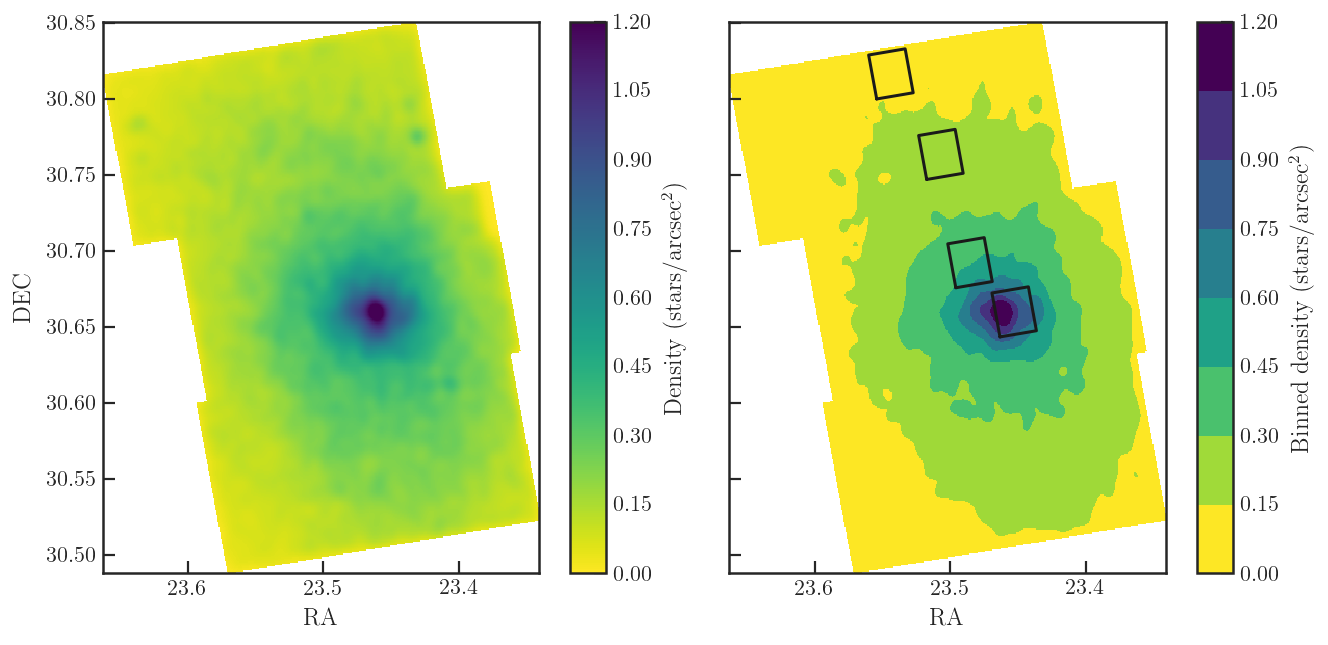

In [5]:
# W14 Fig 10
cmap, ncolors = 'viridis_r', 8
ds.plot('RA','DEC', what=['mean(DENSITY)', 'mean(DENSITY)'], limits='minmax', shape=420, 
        colormap=[cmap, plt.get_cmap(cmap, ncolors)], vmin=0, vmax=1.2,
        colorbar=False, figsize=(8.4, 5.6), interpolation='None')
fig = plt.gcf()
fig.tight_layout(w_pad=4)
ax, ax2 = fig.get_axes()#[0]
ax2.set_yticklabels([])
ax2.set_ylabel('')

cbar = add_colorbar(fig, ax, cmap=cmap, vmin=0, vmax=1.2, #n_colors=ncolors,
                    width=0.03, offset=0.025, label='Density (stars/arcsec$^2$)')
cbar.set_ticks(np.round(np.arange(0, 1.3, 0.15), 2))

cbar = add_colorbar(fig, ax2, cmap=cmap, vmin=0, vmax=1.2, n_colors=ncolors,
                    width=0.03, offset=0.025, label='Binned density (stars/arcsec$^2$)')
cbar.set_ticks(np.round(np.arange(0, 1.3, 0.15), 2))

ax.invert_xaxis()
ax2.invert_xaxis()

fields = ['M33_B01_NN', 'M33_B01_SS', 'M33_B02_NN', 'M33_B02_SS']

dx = dy = 0
for field in fields:
    n = 3 if field.endswith('SS') else 2
    with open(f'../{field}/{field}_{n}.param') as f:
        for line in f:
            if line.startswith('photsec'):
                xmin, xmax = [int(l) for l in line.split()[4::2]]
    ymin, ymax = vaex.open(f'../artstars/{field}_fake_final.hdf5').minmax('Y_IN')
    w = WCS(fits.Header.fromtextfile(f'../{field}/{field}_F475W_drc_wcs.txt'))
    ra, dec = w.all_pix2world(np.c_[[xmin+dx, xmax+dx, xmax+dx, xmin+dx, xmin+dx],
                                    [ymin+dy, ymin+dy, ymax+dy, ymax+dy, ymin+dy]], 0.5).T
    ax2.plot(ra, dec, 'k')

fig.savefig('figures/density_map.pdf', dpi=300, bbox_inches='tight')

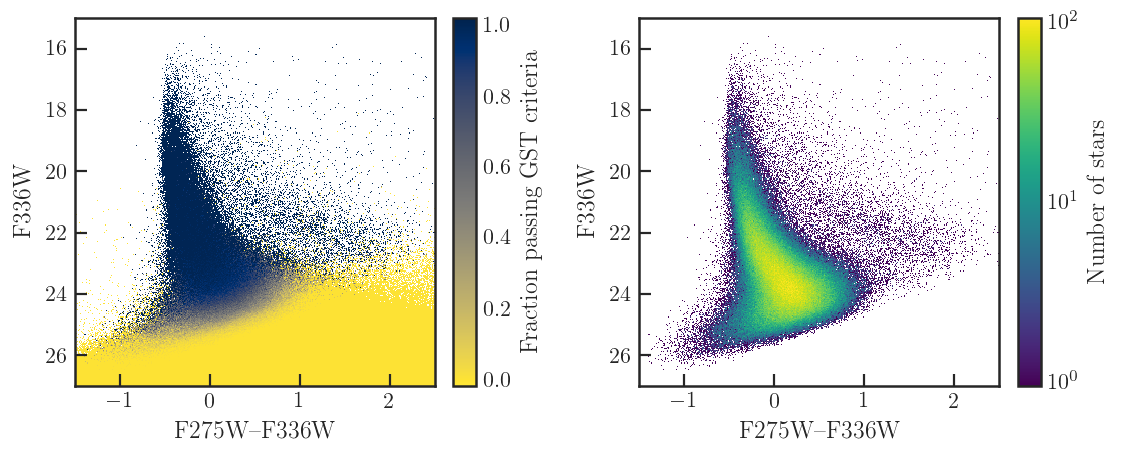

In [6]:
# W14 Fig 9
ds.plot('F275W_VEGA-F336W_VEGA', 'F336W_VEGA', figsize=(7.2, 4), 
        limits=[[-1.5, 2.5], [27, 15]], shape=360, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.95)], vmax=[1.02, np.log10(1.05e2)],
        what=['mean(F275W_GST_FLAG*F336W_GST_FLAG)',
              'sum(F275W_GST_FLAG*F336W_GST_FLAG)'],
        xlabel='F275W--F336W', ylabel='F336W')

fig = plt.gcf()
fig.tight_layout(w_pad=6)

axes = fig.get_axes()

add_colorbar(fig, axes[0], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[1], cmap='viridis', vmin=0.95, vmax=1.05e2,
             norm='LogNorm')

fig.savefig('figures/F275W_F336W_CMDs.pdf', dpi=420, bbox_inches='tight')


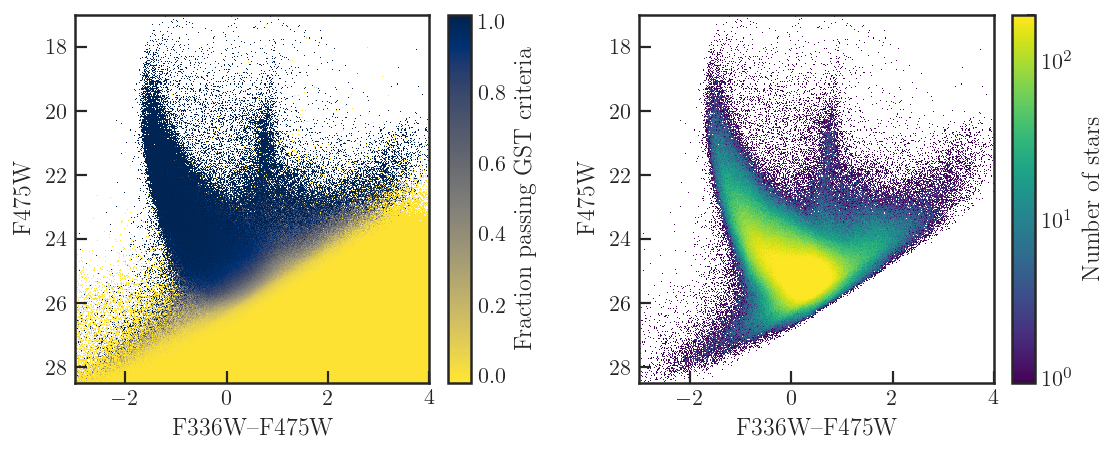

In [7]:
# W14 Fig 11-12
ds.plot('F336W_VEGA-F475W_VEGA', 'F475W_VEGA', figsize=(7.2, 4), 
        limits=[[-3, 4], [28.5, 17]], shape=360, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.95)], vmax=[1.02, np.log10(2e2)],
        what=['mean(F336W_GST_FLAG*F475W_GST_FLAG)',
              'sum(F336W_GST_FLAG*F475W_GST_FLAG)'],
        xlabel='F336W--F475W', ylabel='F475W')

fig = plt.gcf()
fig.tight_layout(w_pad=6)

axes = fig.get_axes()

add_colorbar(fig, axes[0], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[1], cmap='viridis', vmin=0.95, vmax=2e2,
             norm='LogNorm')

fig.savefig('figures/F336W_F475W_CMDs.pdf', dpi=420, bbox_inches='tight')


In [8]:
density_tuples_lo = [(0, 0.15), (0.15, 0.3), (0.3, 0.6)]
density_tuples_hi = [(0.6, 0.9), (0.9, 1.2), (1.2, 100)]

In [9]:
def make_cmd_fig(ds, f_blue, f_red, limits, density_tuples, fig_height=5.6, shape=420, 
                 f_frac=None, f_dens='log10', cmap_frac='cividis_r', cmap_dens='viridis',
                 vmin_frac=-0.02, vmax_frac=1.02, vmin_dens=0.9, vmax_dens=1.1e3,
                 textpos = 'top right'):
    selections = [f'(DENSITY >= {d0}) & (DENSITY < {d1})' for d0, d1 in density_tuples]
    n = len(selections)
    fig_width = n*2.5 + 0.5
    
    ds.plot(f'{f_blue}_VEGA-{f_red}_VEGA', f'{f_red}_VEGA',
            figsize=(fig_width, fig_height), limits=limits, shape=shape, colorbar=False,
            f=[f_frac, f_dens], colormap=[cmap_frac, cmap_dens],
            vmin=[vmin_frac, np.log10(vmin_dens)], vmax=[vmax_frac, np.log10(vmax_dens)],
            what=[f'mean({f_blue}_GST_FLAG*{f_red}_GST_FLAG)',
                  f'sum({f_blue}_GST_FLAG*{f_red}_GST_FLAG)'],
            selection=selections,
            visual=dict(row='what', column='selection'),
            xlabel=f'{f_blue}--{f_red}', ylabel=f_red)
    
    fig = plt.gcf()
    axes = fig.get_axes()
    for ax in axes[1:n] + axes[(n+1):]:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    for ax in axes[:-n]:
        ax.set_xlabel(None)
        ax.set_xticklabels([])
    
    va, ha = textpos.split()
    x = 0.95 if (va == 'top') else 0.05 if (va == 'bottom') else None
    y = 0.95 if (ha == 'right') else 0.05 if (ha == 'left') else None
    for i, (d0, d1) in enumerate(density_tuples):
        for ax in axes[0+i:(n+1)+i:n]:
            dstr = f'{d0} -- {d1}' if (d1 <= 1.2) else f'{d0}+'
            ax.text(x, y, dstr, ha=ha, va=va, transform=ax.transAxes)
    fig.tight_layout(w_pad=0, h_pad=1)

    add_colorbar(fig, axes[-(n+1)], cmap=cmap_frac, vmin=vmin_frac, vmax=vmax_frac,
                 norm='Normalize', label='Fraction passing GST criteria')
    add_colorbar(fig, axes[-1], cmap=cmap_dens, vmin=vmin_dens, vmax=vmax_dens,
                 norm='LogNorm')
    return fig


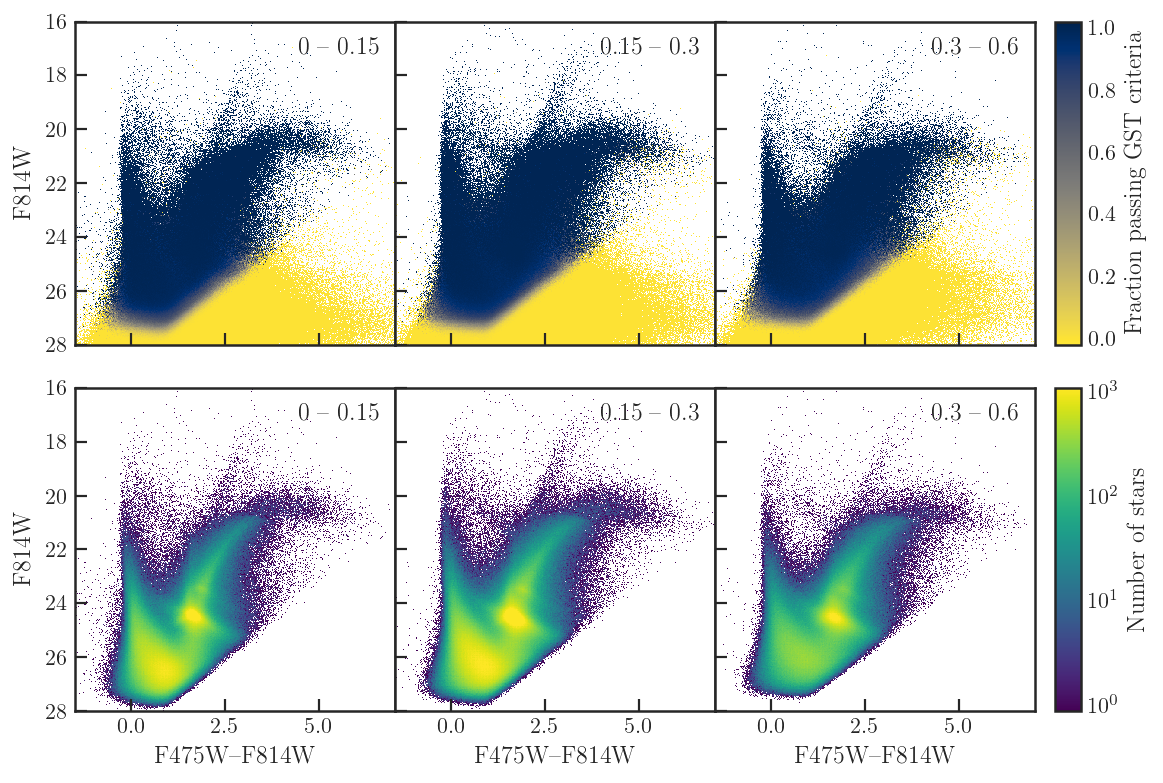

In [10]:
# W14 Fig 13-14
fig = make_cmd_fig(ds, 'F475W', 'F814W', [[-1.5, 7], [28, 16]], density_tuples_lo)
fig.savefig('figures/F475W_F814W_CMDs_low_density.pdf', dpi=420, bbox_inches='tight')


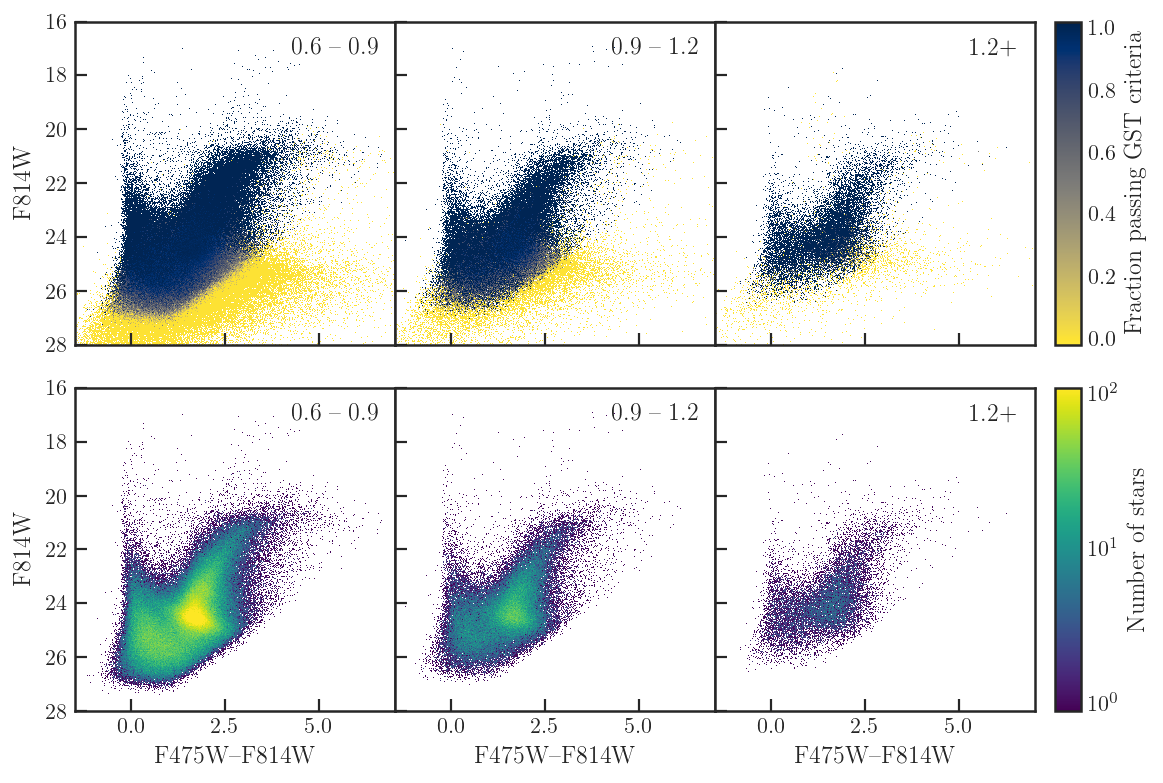

In [11]:
fig = make_cmd_fig(ds, 'F475W', 'F814W', [[-1.5, 7], [28, 16]], density_tuples_hi,
                   vmax_dens=1.1e2)
fig.savefig('figures/F475W_F814W_CMDs_high_density.pdf', dpi=420, bbox_inches='tight')


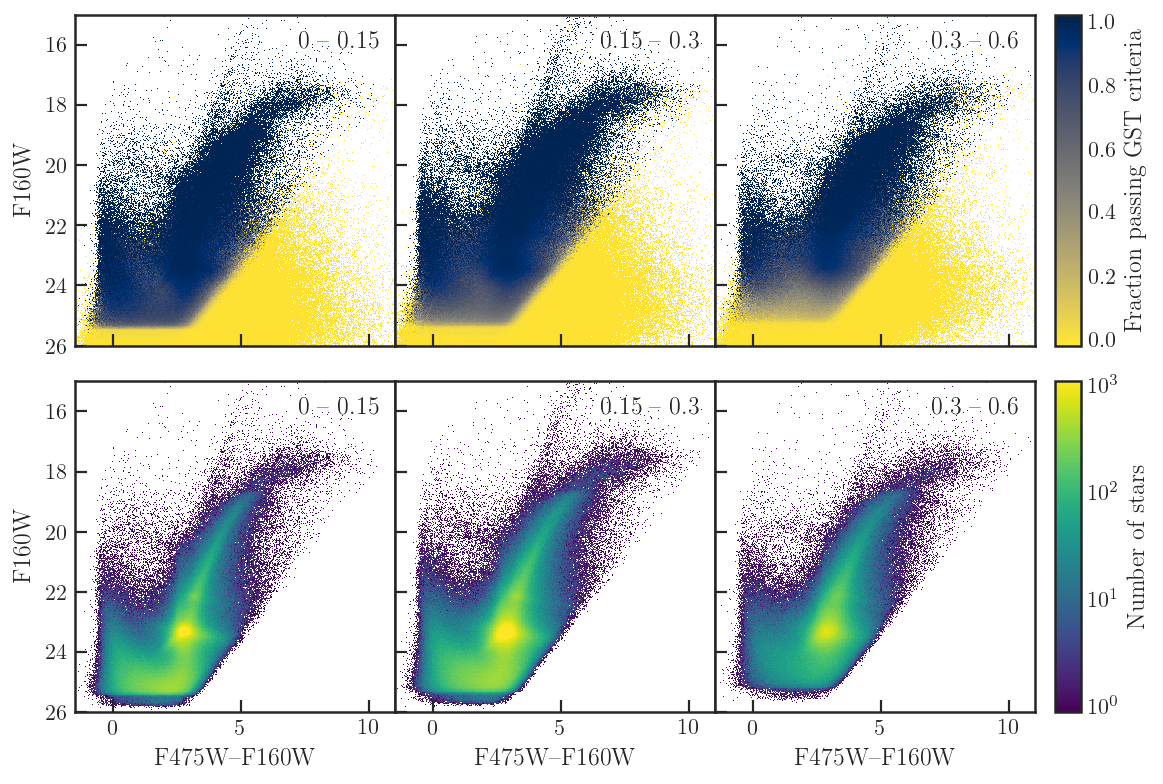

In [12]:
# W14 Fig 15-16
fig = make_cmd_fig(ds, 'F475W', 'F160W', [[-1.5, 11], [26, 15]], density_tuples_lo)
fig.savefig('figures/F475W_F160W_CMDs_low_density.pdf', dpi=420, bbox_inches='tight')


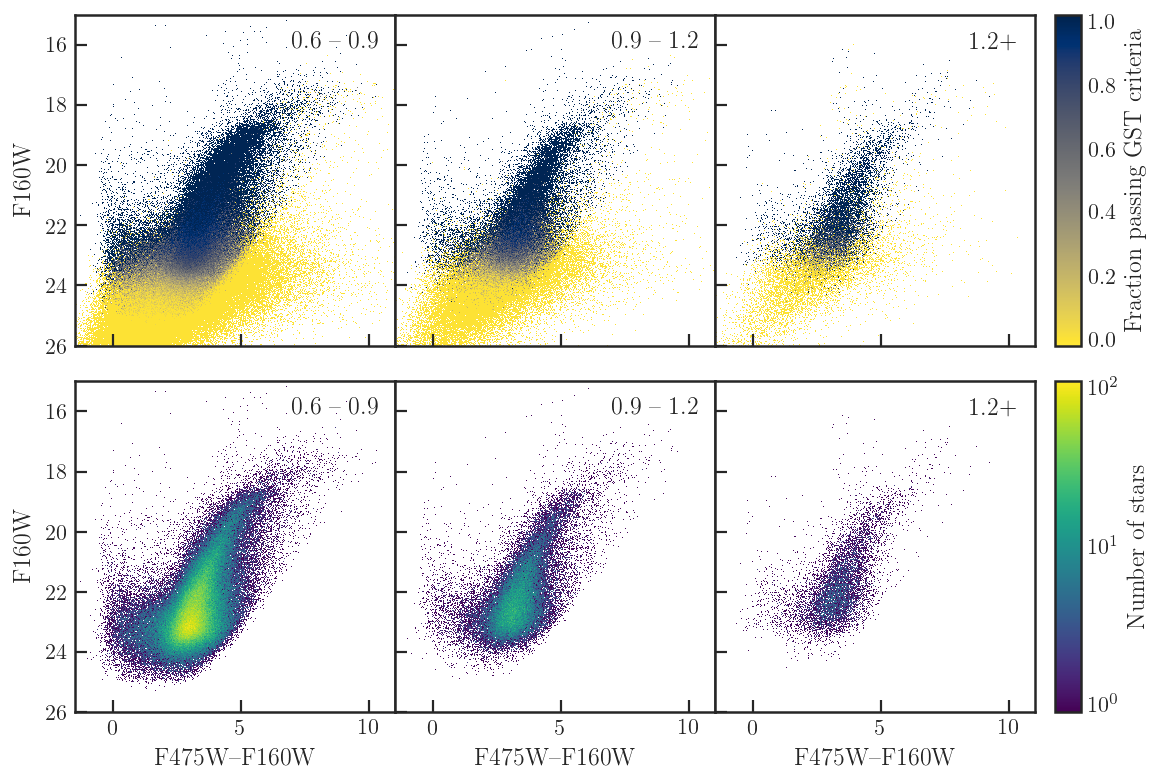

In [13]:
fig = make_cmd_fig(ds, 'F475W', 'F160W', [[-1.5, 11], [26, 15]], density_tuples_hi, vmax_dens=1.1e2)
fig.savefig('figures/F475W_F160W_CMDs_high_density.pdf', dpi=420, bbox_inches='tight')


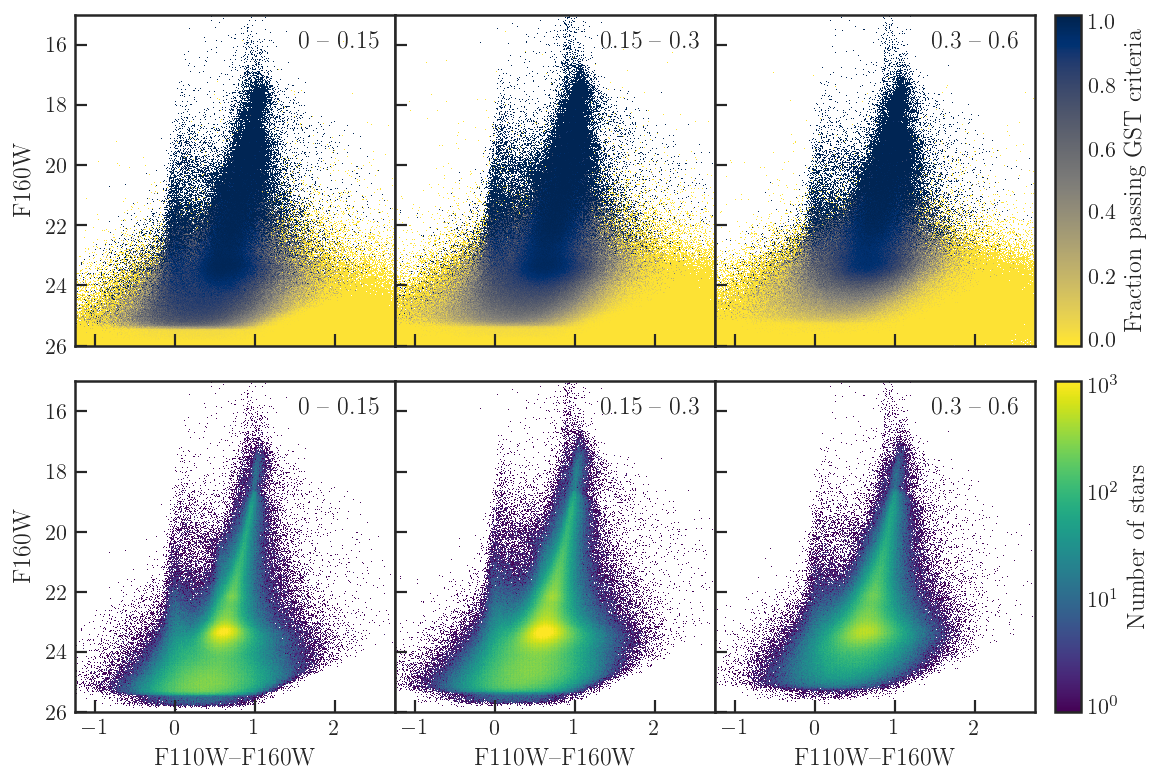

In [14]:
# W14 Fig 17-18
fig = make_cmd_fig(ds, 'F110W', 'F160W', [[-1.25, 2.75], [26, 15]], density_tuples_lo)
fig.savefig('figures/F110W_F160W_CMDs_low_density.pdf', dpi=420, bbox_inches='tight')


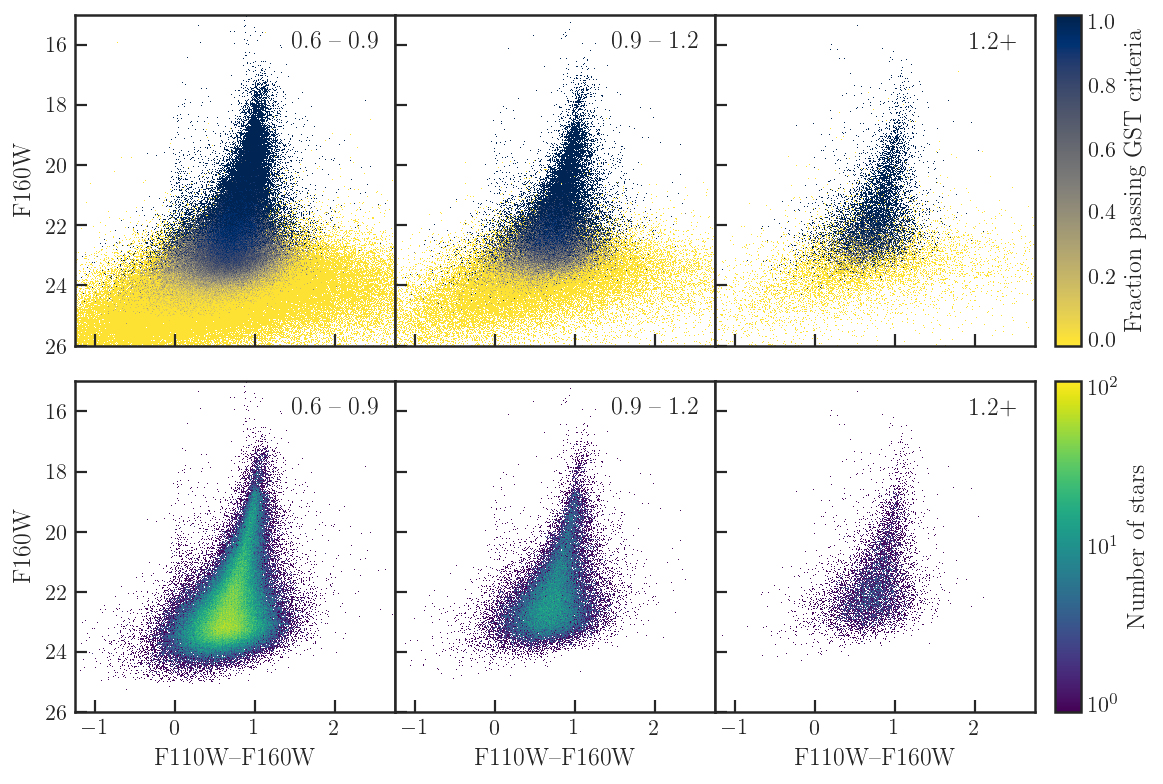

In [15]:
fig = make_cmd_fig(ds, 'F110W', 'F160W', [[-1.25, 2.75], [26, 15]], density_tuples_hi, vmax_dens=1.1e2)
fig.savefig('figures/F110W_F160W_CMDs_high_density.pdf', dpi=420, bbox_inches='tight')


In [16]:
n_det = ds.evaluate('+'.join(ds.get_column_names(regex='F.*?W_GST_FLAG')))
if 'n_detected' in ds.get_column_names():
    ds.drop('n_detected', inplace=True)
ds.add_column('n_detected', n_det)

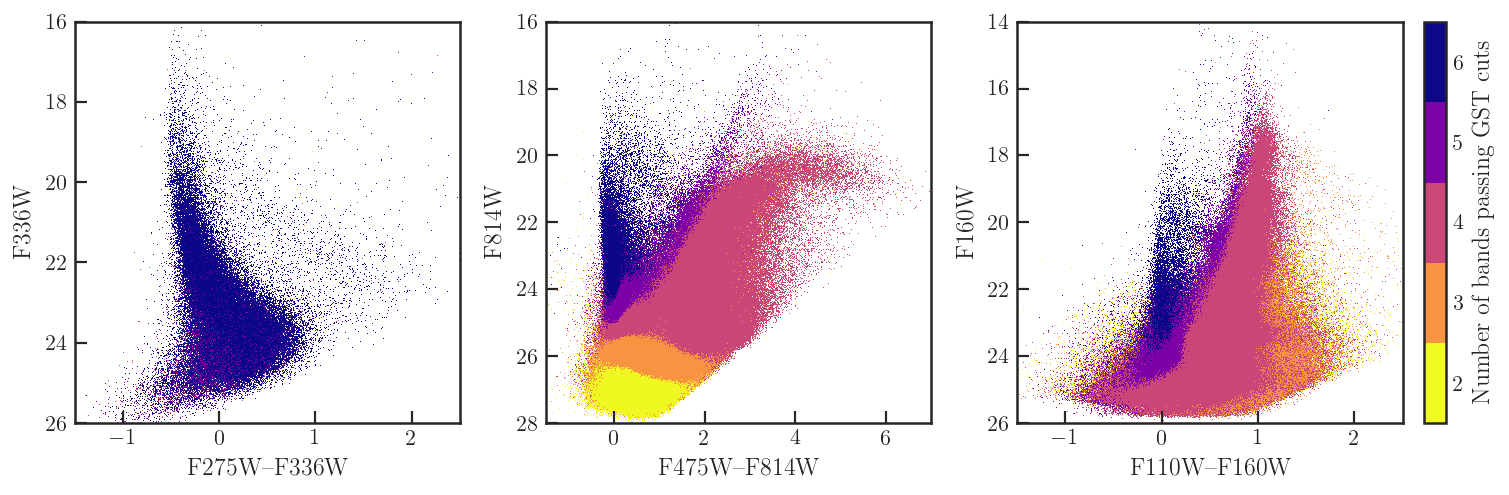

In [17]:
# W14 Fig 8

colormap_frac, vmin_frac, vmax_frac = plt.cm.get_cmap('plasma_r', 5), 1.5, 6.5
cmap_frac = colormap_frac #getattr(mpl.cm, colormap_frac)
norm_frac = mpl.colors.Normalize(vmin_frac, vmax_frac)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3.6))

plt.sca(ax0)
ds.plot('F275W_VEGA-F336W_VEGA', 'F336W_VEGA', limits=[[-1.5, 2.5], [26, 16]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F275W--F336W', ylabel='F336W', selection=['UV_GST & (DENSITY < 0.15)'])

plt.sca(ax1)
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=[[-1.5, 7], [28, 16]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F475W--F814W', ylabel='F814W', selection=['OPT_GST & (DENSITY < 0.15)'])

plt.sca(ax2)
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', limits=[[-1.5, 2.5], [26, 14]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F110W--F160W', ylabel='F160W', selection=['IR_GST & (DENSITY < 0.15)'])

fig.tight_layout()

cbar = add_colorbar(fig, ax2, cmap='plasma_r', vmin=1.5, vmax=6.5,
                    norm='Normalize', n_colors=5,
                    offset=0.015, width=0.015, label='Number of bands passing GST cuts')

fig.savefig('figures/nbands_cmds.pdf', dpi=420, bbox_inches='tight')

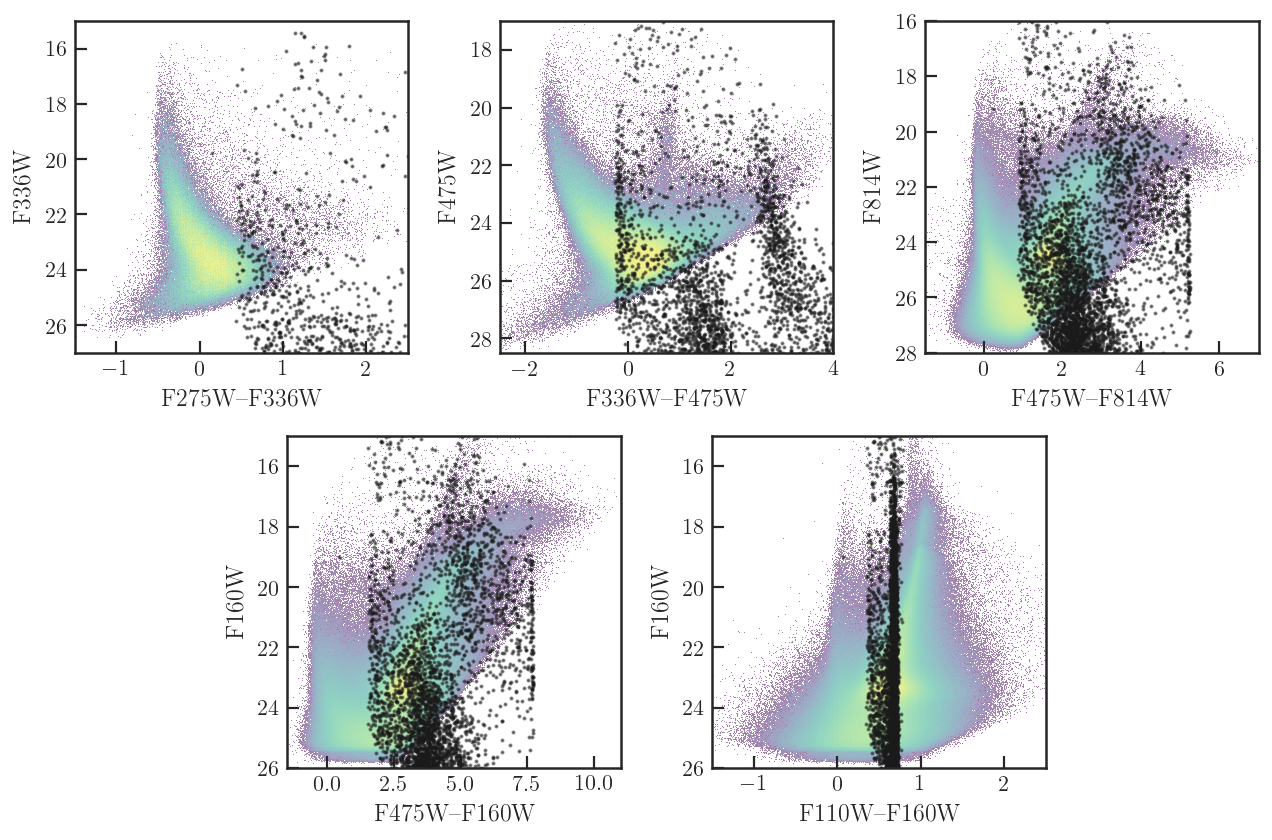

In [18]:
df = pd.read_csv('data/triout_m33_frg_260sqrarcmin.dat', delim_whitespace=True,
                 ).rename(columns=lambda x: x.replace('mag','').replace('W1','W'))

fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(2, 6)

plot_kwargs = dict(s=1, color='k', alpha=0.5)

def add_ax(gs0, gs1, f_blue, f_red, x0, x1, y0, y1, include_phot=True, plot_kwargs=plot_kwargs):
    ax = fig.add_subplot(gs[gs0, gs1])
    ax.scatter(df[f_blue]-df[f_red], df[f_red], **plot_kwargs)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if include_phot:
        plt.sca(ax)
        ds.plot(f'{f_blue}_VEGA-{f_red}_VEGA', f'{f_red}_VEGA', f='log10', 
                colorbar=False, limits=[[x0, x1], [y0, y1]], colormap='viridis',
                selection=[f'{f_blue}_GST & {f_red}_GST', 'F110W_VEGA < 0'],
                xlabel=f'{f_blue}--{f_red}', ylabel=f_red, shape=420)
    else:
        ax.set_xlabel(f'{f_blue}--{f_red}')
        ax.set_ylabel(f_red)

add_ax(slice(0,1), slice(0,2), 'F275W', 'F336W', *[-1.5, 2.5], *[27, 15])
add_ax(slice(0,1), slice(2,4), 'F336W', 'F475W', *[-2.5, 4  ], *[28.5, 17])
add_ax(slice(0,1), slice(4,6), 'F475W', 'F814W', *[-1.5, 7  ], *[28, 16])
add_ax(slice(1,2), slice(1,3), 'F475W', 'F160W', *[-1.5, 11 ], *[26, 15])
add_ax(slice(1,2), slice(3,5), 'F110W', 'F160W', *[-1.5, 2.5], *[26, 15])

fig.tight_layout()
fig.savefig('figures/trilegal_foreground_withCMDs.pdf', dpi=420, bbox_inches='tight')

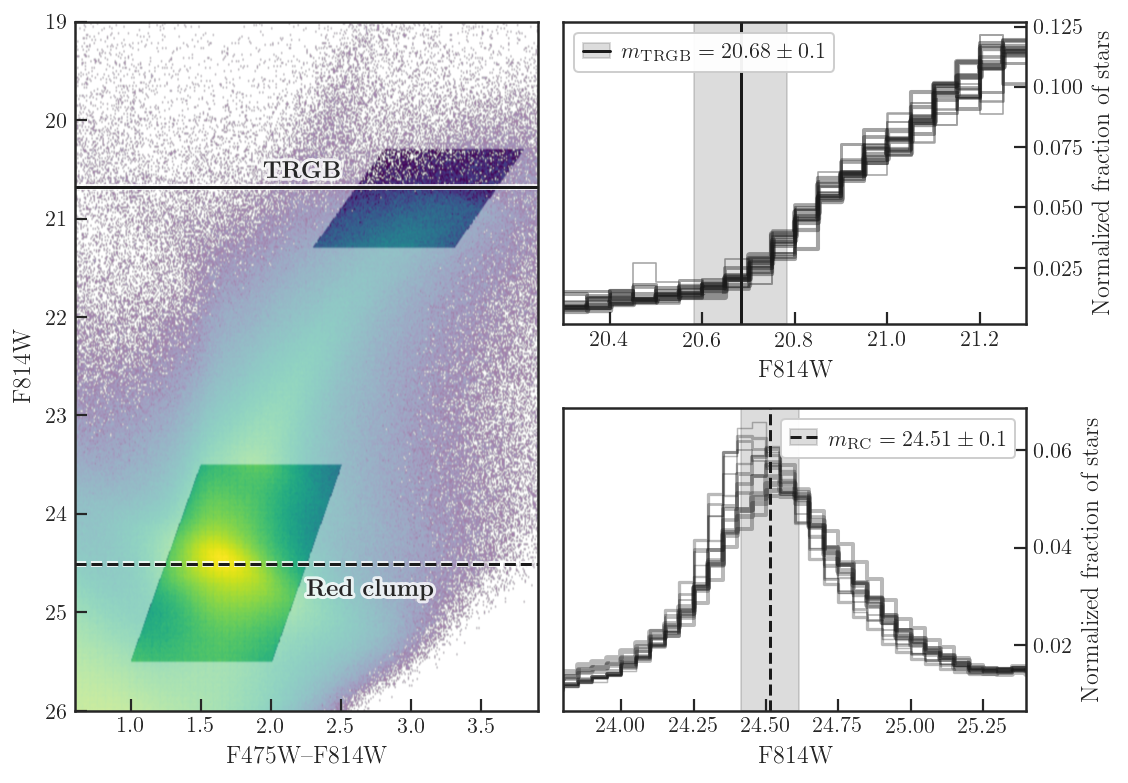

In [19]:
ds.select_lasso('F475W_VEGA-F814W_VEGA', 'F814W_VEGA',
                [2.3, 3.3, 3.8, 2.8], [21.3, 21.3, 20.3, 20.3],
                name='trgb')
ds.select_lasso('F475W_VEGA-F814W_VEGA', 'F814W_VEGA',
                [1, 2, 2.5, 1.5], [25.5, 25.5, 23.5, 23.5],
                name='rc')

dmod, A814 = 24.67, 0.063
Mtrgb, Mrc = -4.05, -0.22
etrgb = erc = 0.1 
mtrgb = Mtrgb + dmod + A814
mrc = Mrc + dmod + A814

fig = plt.figure(figsize=(8, 5.6))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0:2, 0:1])
ax1 = fig.add_subplot(gs[0:1, 1:2])
ax2 = fig.add_subplot(gs[1:2, 1:2])

plt.sca(ax)
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=[[0.6, 3.9], [26, 19]],
        colormap='viridis', f='log10', colorbar=False, 
        interpolation='bicubic', shape=420, xlabel='F475W--F814W', ylabel='F814W',
        selection=['OPT_GST', 'OPT_GST & (trgb|rc)'])
stroke = patheffects.withStroke(linewidth=3, foreground='w', alpha=0.8)
ax.axhline(mtrgb, color='k', linestyle='-', path_effects=[stroke])
ax.axhline(mrc, color='k', linestyle='--', path_effects=[stroke])
ax.text(2.5, mtrgb-0.05, r'\textbf{TRGB}', ha='right', va='bottom', path_effects=[stroke])
ax.text(2.25, mrc+0.15, r'\textbf{Red clump}', ha='left', va='top', path_effects=[stroke])

nbins_ra = 3
nbins_dec = 4
ras = ds.bin_edges('RA', limits=ds.minmax('RA'), shape=nbins_ra)
decs = ds.bin_edges('DEC', limits=ds.minmax('DEC'), shape=nbins_dec)

for i, j in product(range(nbins_ra), range(nbins_dec)):
    ds.select_box(['RA', 'DEC'], [[ras[i], ras[i+1]], [decs[j], decs[j+1]]],
                  name='tmp_subregion')
    lw_trgb = (ds.selected_length('tmp_subregion & trgb & F814W_GST') / 1e3)**0.5
    plt.sca(ax1)
    ds.plot1d('F814W_VEGA', selection='tmp_subregion & trgb & F814W_GST', n='normalize',
              shape=20, limits=[20.3, 21.3], color='k', lw=lw_trgb, alpha=0.4,
              xlabel='F814W', ylabel='Normalized fraction of stars')
    lw_rc = (ds.selected_length('tmp_subregion & rc & F814W_GST') / 1e5)**0.5
    plt.sca(ax2)
    ds.plot1d('F814W_VEGA', selection='tmp_subregion & rc & F814W_GST', n='normalize',
              shape=40, limits=[23.5, 25.5], color='k', lw=lw_rc, alpha=0.3,
              xlabel='F814W', ylabel='Normalized fraction of stars')
ax1.set_xlim(20.3, 21.3)
ax2.set_xlim(23.8, 25.4)

for ax_, mag, err, label, ls in zip([ax1, ax2], [mtrgb, mrc], [etrgb, erc],
                                    ['TRGB', 'RC'], ['-', '--']):
    ax_.yaxis.set_label_position("right")
    ax_.yaxis.tick_right()
    ylim = ax_.get_ylim()
    ax_.set_ylim(ylim)
    line = ax_.axvline(mag, color='k', linestyle=ls)
    ptch = ax_.fill_betweenx(ylim, mag-err, mag+err, color='k', alpha=0.15)
    label_str = '$m_{\mathrm{' + label + '}}=' + f'{mag:.2f}\pm{err:.1f}$'
    ax_.legend(handles=[(ptch, line)], labels=[label_str], loc='best',
               handlelength=1.2, handler_map={tuple: HandlerTuple(ndivide=1)})

fig.tight_layout()
fig.savefig('figures/rgb_rc_lfs.pdf', dpi=420, bbox_inches='tight')

/astro/users/mdurbin/miniconda3/envs/astroconda_dev/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


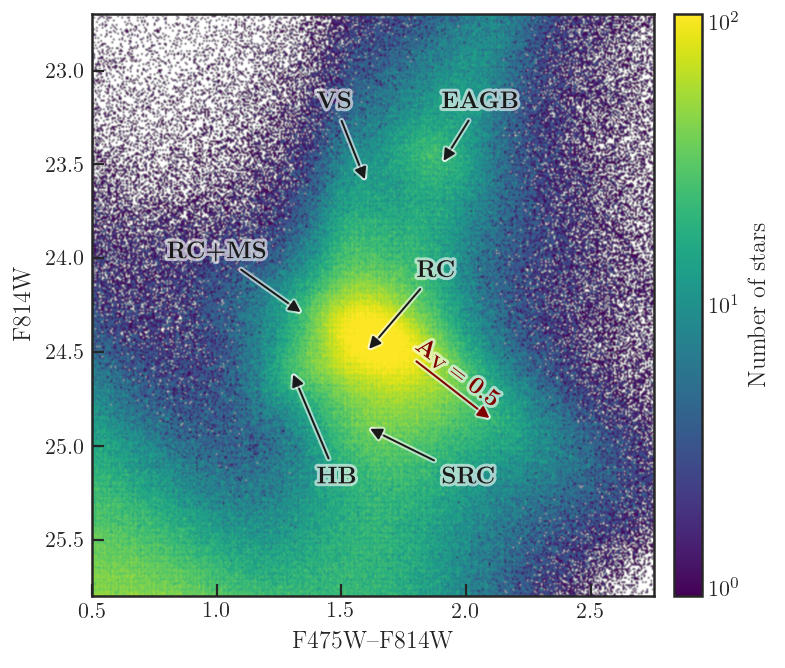

In [20]:
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', f='log10', selection='OPT_GST & (DENSITY < 0.15)',
        limits=[[0.5, 2.75], [25.8, 22.7]], colormap='viridis', shape=400,
        interpolation='bicubic', vmin=np.log10(0.95), vmax=2.03, colorbar=False, 
        figsize=(4.8, 4.8), xlabel='F475W--F814W', ylabel='F814W')
fig, ax = plt.gcf(), plt.gca()

stroke = patheffects.withStroke(linewidth=3, foreground='w', alpha=0.6)
arrowprops = dict(arrowstyle='-|>', color='k', path_effects=[stroke])
annot_kwargs = dict(color='k', size=12, arrowprops=arrowprops,
                    path_effects=[stroke])

ax.annotate('', xytext=(1.8, 24.55), xy=(1.8+0.5*(1.19119-0.60593), 24.55+0.5*0.60593),
            path_effects=[stroke], color='maroon', xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-|>', color='maroon', path_effects=[stroke],
                            shrinkA=0, shrinkB=0))
ax.text(1.78, 24.8, r'$\bf{A_V=0.5}$', zorder=2, rotation=-37, color='maroon',
        size=12, path_effects=[stroke])
ax.annotate(r'\textbf{RC}', xy=(1.6, 24.5), xytext=(1.8, 24.1), **annot_kwargs)
ax.annotate(r'\textbf{SRC}', xy=(1.6, 24.9), xytext=(1.9, 25.2), **annot_kwargs)
ax.annotate(r'\textbf{EAGB}', xy=(1.9, 23.5), xytext=(1.9, 23.2), **annot_kwargs)
ax.annotate(r'\textbf{HB}', xy=(1.3, 24.6), xytext=(1.4, 25.2), **annot_kwargs)
ax.annotate(r'\textbf{VS}', xy=(1.6, 23.6), xytext=(1.4, 23.2), **annot_kwargs)
ax.annotate(r'\textbf{RC+MS}', xy=(1.35, 24.3), xytext=(0.8, 24), **annot_kwargs)

cb = add_colorbar(fig, ax, cmap='viridis', vmin=0.95, vmax=10**2.03,
                  norm='LogNorm', offset=0.03, width=0.04)

fig.tight_layout()
fig.savefig('figures/zoomed_cmd.pdf', dpi=420, bbox_inches='tight')

In [21]:
ds.select_lasso('F475W_VEGA-F814W_VEGA', 'F814W_VEGA',
                [1, 2, 2.5, 1.5], [25, 25, 24, 24],
                name='rc')
ds.select('F814W_GST', mode='and', name='rc')

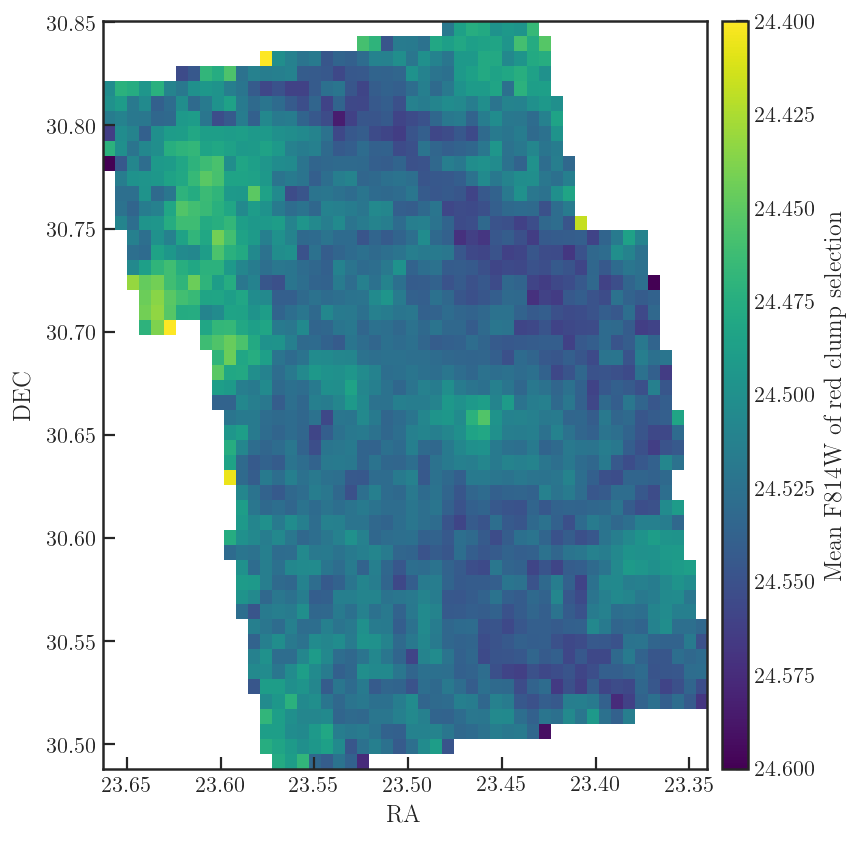

In [22]:
ds.plot('RA', 'DEC', what='mean(F814W_VEGA)', selection='rc', xlabel='RA', ylabel='DEC',
        colorbar=False, shape=50, colormap='viridis_r', aspect=1.1,
        figsize=(6,6), vmin=24.4, vmax=24.6, tight_layout=True)
plt.gca().invert_xaxis()
cb = add_colorbar(plt.gcf(), plt.gca(), cmap='viridis_r', width=0.03, vmin=24.4, vmax=24.6,
             label='Mean F814W of red clump selection')
cb.ax.invert_yaxis()

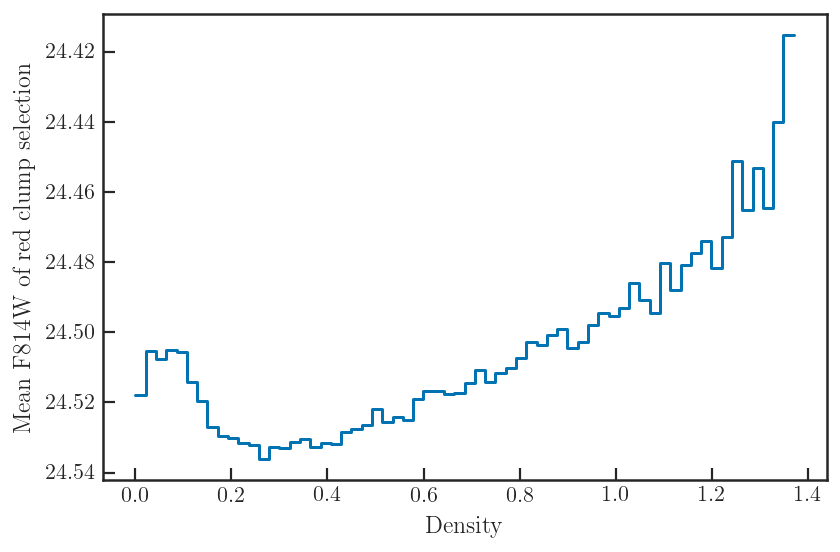

In [23]:
ds.plot1d('DENSITY', what='mean(F814W_VEGA)', selection='rc', xlabel='Density',
          ylabel='Mean F814W of red clump selection')
plt.gca().invert_yaxis()